# This notebook

This notebook contains first bits and pieces of the yet to be developed model correlating climate/environmental factors with conflict occurrence.

## Import libraries and file with settings

In [1]:
import conflict_model

import pandas as pd
import geopandas as gpd
from configparser import RawConfigParser
import matplotlib.pyplot as plt
import numpy as np
import datetime
import rasterstats as rstats
import xarray as xr
import rasterio as rio
import seaborn as sbs
import os, sys

In [2]:
conflict_model.utils.show_versions()

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
conflict_model version: 0.0.1-beta
geopandas version: 0.7.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
matplotlib version: 3.2.1
rasterstats version: 0.14.0


Geopandas versions lower than 0.7.0 do not yet have the clip function. The notebook will thus not work with these versions.

In [3]:
if gpd.__version__ < '0.7.0':
    sys.exit('please upgrade geopandas to version 0.7.0, your current version is {}'.format(gpd.__version__))

In this file all the settings for the analysis are defined. By 'parsing' it, all values are read for different sections. This is a simple way to make the code independent of the input data and settings.

In [4]:
settings_file = r'../data/run_setting.cfg'

In [5]:
config = RawConfigParser(allow_no_value=True)
config.read(settings_file)

['../data/run_setting.cfg']

In [6]:
#out_dir
out_dir = config.get('general','output_dir')
if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
print('for the record, saving output to folder {}'.format(out_dir) + os.linesep)

for the record, saving output to folder C:\Users\hoch0001\Documents\_code\conflict_model\data\OUT



# Applying functions

In [7]:
gdf = conflict_model.utils.get_geodataframe(config)

reading csv file to dataframe C:\Users\hoch0001\Documents\_code\conflict_model\data\UCDP/ged191.csv
...DONE

translating to geopandas dataframe
...DONE



In [8]:
conflict_gdf, extent_gdf = conflict_model.selection.select(gdf, config)

filtering on conflict properties...
...filtering key best with lower value 5
...filtering key type_of_violence with value 1
...passing key country as it is empty
focussing on period between 2000 and 2005

reading extent and spatial aggregation level from file C:\Users\hoch0001\Documents\_code\conflict_model\data\waterProvinces/waterProvinces_Africa.shp
...DONE

clipping datasets to extent
...DONE

clipping to climate zones['BWh', 'BSh']
...DONE



# Functions

In [10]:
def conflict_in_year_bool(conflict_gdf, extent_gdf, config, sim_year, out_dir, saving_plots=False, showing_plots=False):
    
    print('determining whether a conflict took place or not...')
    
    out_df = extent_gdf.copy()
    # each year initialize new column with default value 0 (=False)
    out_df['boolean_conflict_' + str(sim_year)] = 0
#     out_df['sum_fatalities_' + str(sim_year)] = 0 # not needed atm
    
    # select the entries which occured in this year
    temp_sel_year = conflict_gdf.loc[conflict_gdf.year == sim_year]   
    
    data_merged = gpd.sjoin(temp_sel_year, out_df)
    
    fatalities_per_watProv = data_merged['best'].groupby(data_merged['watprovID']).sum().to_frame().rename(columns={"best": 'bla'})
 
    for i in range(len(out_df)):
        i_watProv = out_df.iloc[i]['watprovID']
        if i_watProv in fatalities_per_watProv.index.values:
            fats = int(fatalities_per_watProv.loc[i_watProv])
            out_df.loc[i, 'boolean_conflict_' + str(sim_year)] = 1
#             out_df.loc[i, 'sum_fatalities_' + str(sim_year)] = fats # not needed atm
        
    if not len(extent_gdf) == len(out_df):
        raise AssertionError('lengths do not match!')
        
    print('...DONE' + os.linesep)

    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    ax.set_title('boolean_conflict_' + str(sim_year))
    out_df.plot(ax=ax, column='boolean_conflict_' + str(sim_year), legend=True, categorical=True)
    plt.tight_layout()
    
    if saving_plots:
        fn_out = os.path.join(out_dir, 'boolean_conflict_map_' + str(sim_year) + '.png')
        plt.savefig(fn_out, dpi=300)

    if not showing_plots:
        plt.close()

    return out_df, data_merged, fatalities_per_watProv

# Analysis per year

In a first step, we want to know in which countries there was conflict or not. To that end, we first accumulate the number of fatalities per country and use this as proxy whether there was a conlfict or not (guess there is a rather strong like...).

simulation period from 2000 to 2005

entering year 2000

determining whether a conflict took place or not...
...DONE

calculating zonal statistics per aggregation unit


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE



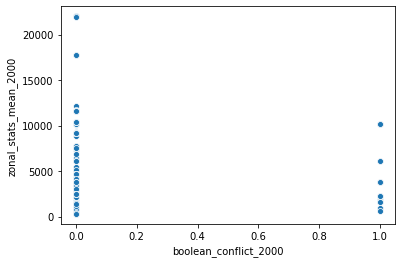

entering year 2001

determining whether a conflict took place or not...
...DONE

calculating zonal statistics per aggregation unit


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE



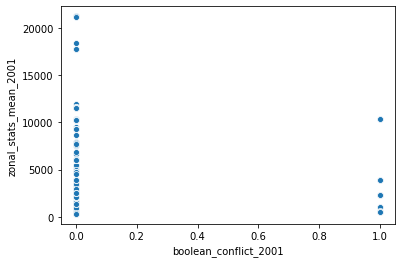

entering year 2002

determining whether a conflict took place or not...
...DONE

calculating zonal statistics per aggregation unit


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE



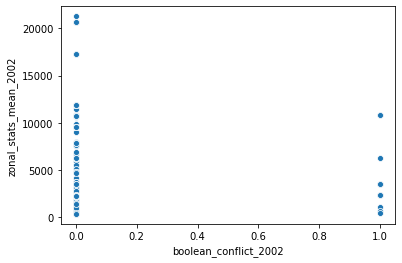

entering year 2003

determining whether a conflict took place or not...
...DONE

calculating zonal statistics per aggregation unit


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE



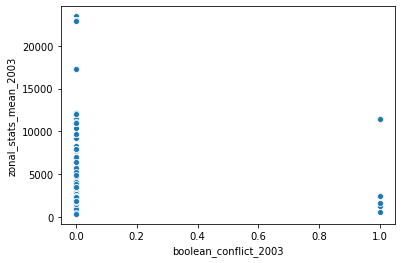

entering year 2004

determining whether a conflict took place or not...
...DONE

calculating zonal statistics per aggregation unit


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE



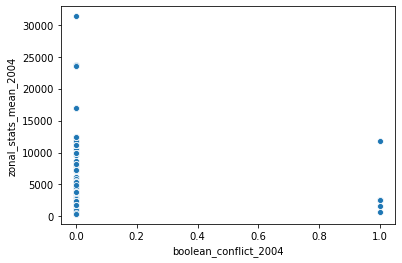

...simulation DONE


In [13]:
print('simulation period from', str(config.getint('settings', 'y_start')), 'to', str(config.getint('settings', 'y_end')))
print('')

for sim_year in np.arange(config.getint('settings', 'y_start'), config.getint('settings', 'y_end'), 1):
    
    print('entering year {}'.format(sim_year) + os.linesep)
    
    out_df, data_merged, fatalities_per_watProv = conflict_in_year_bool(conflict_gdf, extent_gdf, config, sim_year, out_dir, saving_plots=True)
    
    out_df = conflict_model.env_vars_nc.rasterstats_GDP_PPP(out_df, config, sim_year, out_dir, saving_plots=True)
    
    sbs.scatterplot(x='boolean_conflict_' + str(sim_year), y='zonal_stats_mean_' + str(sim_year), data=out_df)
    plt.show()
    
    extent_gdf = out_df.copy()

print('...simulation DONE')